In [1]:
import tqdm
import pandas
import scipy

In [2]:
failed_experiments = []
for d1 in tqdm.tqdm(range(1,7)):
    for d2 in range(d1,7):
        for d3 in range(d2,7):
            for d4 in range(1,7):
                for d5 in range(d4,7):
                    for d6 in range(d5,7):
                        outcome = scipy.stats.ttest_ind([d1,d2,d3], [d4,d5,d6], equal_var=False)
                        failed_experiments.append({
                            'control1': d1, 
                            'control2': d2, 
                            'control3': d3, 
                            'experimental1': d4, 
                            'experimental2': d5, 
                            'experimental3': d6,
                            'was_successful': False,
                            'welch_result': outcome.pvalue < 0.05,
                            'welch_pvalue': outcome.pvalue
                                                  })
failed_experiments = pandas.DataFrame.from_records(failed_experiments)
failed_experiments.shape

  0%|                                                     | 0/6 [00:00<?, ?it/s]/var/folders/s9/qjnh_3gd73d2l2wy70bcdplh0000gn/T/ipykernel_10391/31582589.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  outcome = scipy.stats.ttest_ind([d1,d2,d3], [d4,d5,d6], equal_var=False)
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.98it/s]


(3136, 9)

In [3]:
successful_experiments = []
for d1 in tqdm.tqdm(range(1,7)):
    for d2 in range(d1,7):
        for d3 in range(d2,7):
            for d4 in range(1,9):
                for d5 in range(d4,9):
                    for d6 in range(d5,9):
                        outcome = scipy.stats.ttest_ind([d1,d2,d3], [d4,d5,d6], equal_var=False)
                        successful_experiments.append({
                            'control1': d1, 
                            'control2': d2, 
                            'control3': d3, 
                            'experimental1': d4, 
                            'experimental2': d5, 
                            'experimental3': d6,
                            'was_successful': True,
                            'welch_result': outcome.pvalue < 0.05,
                            'welch_pvalue': outcome.pvalue
                                                  })
successful_experiments = pandas.DataFrame.from_records(successful_experiments)
successful_experiments.shape

  0%|                                                     | 0/6 [00:00<?, ?it/s]/var/folders/s9/qjnh_3gd73d2l2wy70bcdplh0000gn/T/ipykernel_10391/1791494485.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  outcome = scipy.stats.ttest_ind([d1,d2,d3], [d4,d5,d6], equal_var=False)
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.77it/s]


(6720, 9)

In [4]:
failed_experiments.welch_result.value_counts()

False    2878
True      258
Name: welch_result, dtype: int64

In [5]:
successful_experiments.welch_result.value_counts()

False    6066
True      654
Name: welch_result, dtype: int64

In [6]:
df = pandas.concat([failed_experiments, successful_experiments])
control_columns = ['control1', 'control2', 'control3']
experiment_columns = ['experimental1', 'experimental2', 'experimental3']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PolynomialFeatures
import sklearn.model_selection
import sklearn.metrics
import differencer
import typescorers

custom_transformer = differencer.ControlExperimentalDifferencer(3, 3)
#custom_transformer = differencer.ControlExperimentalDifferencer(3, 3, include_original_values=True)
poly_features = PolynomialFeatures(degree=2)
#log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, class_weight='balanced')
log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, class_weight={False: 100, True: 1})

calibrated_clf = CalibratedClassifierCV(base_estimator=log_reg, method='sigmoid')

# Constructing the pipeline
pipeline = Pipeline([
    ('feature_difference', custom_transformer),
    ('poly_features', poly_features),
    ('classifier', calibrated_clf)
])


In [67]:
custom_transformer = differencer.ControlExperimentalDifferencer(3, 3)
#custom_transformer = differencer.ControlExperimentalDifferencer(3, 3, include_original_values=True)
poly_features = PolynomialFeatures(degree=2)
log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, class_weight='balanced')
#log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, class_weight={False: 100, True: 1})

calibrated_clf = CalibratedClassifierCV(base_estimator=log_reg, method='sigmoid')

# Constructing the pipeline
pipeline = Pipeline([
    ('feature_difference', custom_transformer),
    ('poly_features', poly_features),
    ('classifier', log_reg)
])


In [68]:
pipeline.fit(df[control_columns + experiment_columns], df.was_successful)

/Users/gregb/miniconda3/lib/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('feature_difference',
                 ControlExperimentalDifferencer(control_group_size=3,
                                                experiment_group_size=3)),
                ('poly_features', PolynomialFeatures()),
                ('classifier',
                 CalibratedClassifierCV(base_estimator=LogisticRegression(class_weight='balanced',
                                                                          max_iter=1000,
                                                                          penalty=None)))])

In [69]:
# in this case, it actually does make sense to test on the training data!
predictions = pipeline.predict(df[control_columns + experiment_columns])

In [70]:
sklearn.metrics.confusion_matrix(df.was_successful, predictions)

array([[1214, 1922],
       [1252, 5468]])

In [71]:
sklearn.metrics.confusion_matrix(df.was_successful, df.welch_result)

array([[2878,  258],
       [6066,  654]])

In [72]:
df['bmap3_result'] = predictions
df['bmap3_probability'] = [x[1] for x in pipeline.predict_proba(df[control_columns + experiment_columns])]

In [73]:
import sklearn.ensemble
rfc = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')
rfc.fit(df[control_columns + experiment_columns], df.was_successful)
rfc_predictions = rfc.predict(df[control_columns + experiment_columns])
df['bmap1_result'] = rfc_predictions

In [74]:
df.groupby(['was_successful', 'welch_result', 'bmap3_result']).control1.count()

was_successful  welch_result  bmap3_result
False           False         False           1154
                              True            1724
                True          False             60
                              True             198
True            False         False           1188
                              True            4878
                True          False             64
                              True             590
Name: control1, dtype: int64

In [75]:
w = df[~df.was_successful].welch_result.value_counts()
w = 100.0 * w / w.sum()
b = df[~df.was_successful].bmap3_result.value_counts()
b = 100.0 * b / b.sum()
b1 = df[~df.was_successful].bmap1_result.value_counts()
b1 = 100.0 * b1 / b1.sum()
print(f"""For unsuccessful experiments:
  Welch will be correct {w[False]}% of the time.
  Welch will be incorrect {w[True]}% of the time.
  BMAP1 will be correct {b1[False]}% of the time.
  BMAP1 will be incorrect {b1[True]}% of the time.
  BMAP3 will be correct {b[False]}% of the time.
  BMAP3 will be incorrect {b[True]}% of the time.
  
  """)
w = df[df.was_successful].welch_result.value_counts()
w = 100.0 * w / w.sum()
b = df[df.was_successful].bmap3_result.value_counts()
b = 100.0 * b / b.sum()
b1 = df[df.was_successful].bmap1_result.value_counts()
b1 = 100.0 * b1 / b1.sum()
print(f"""For successful experiments:
  Welch will be correct {w[True]}% of the time.
  Welch will be incorrect {w[False]}% of the time.
  BMAP1 will be correct {b1[True]}% of the time.
  BMAP1 will be incorrect {b1[False]}% of the time.
  BMAP3 will be correct {b[True]}% of the time.
  BMAP3 will be incorrect {b[False]}% of the time.
  """)

For unsuccessful experiments:
  Welch will be correct 91.77295918367346% of the time.
  Welch will be incorrect 8.22704081632653% of the time.
  BMAP1 will be correct 97.51275510204081% of the time.
  BMAP1 will be incorrect 2.4872448979591835% of the time.
  BMAP3 will be correct 38.71173469387755% of the time.
  BMAP3 will be incorrect 61.28826530612245% of the time.
  
  
For successful experiments:
  Welch will be correct 9.732142857142858% of the time.
  Welch will be incorrect 90.26785714285714% of the time.
  BMAP1 will be correct 54.49404761904762% of the time.
  BMAP1 will be incorrect 45.50595238095238% of the time.
  BMAP3 will be correct 81.36904761904762% of the time.
  BMAP3 will be incorrect 18.63095238095238% of the time.
  


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

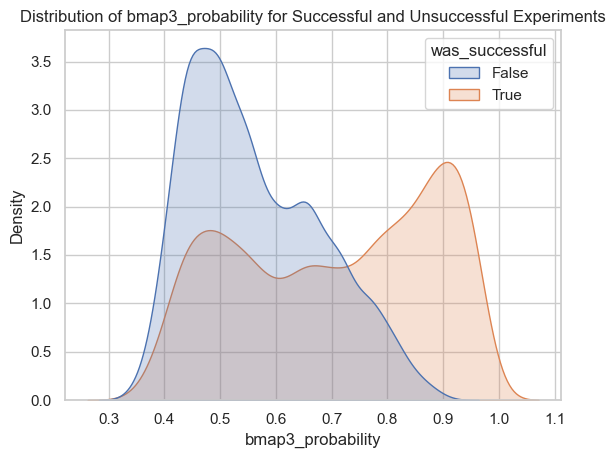

In [17]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot KDE
sns.kdeplot(
    data=df,
    x="bmap3_probability",
    hue="was_successful",
    common_norm=False,  # To scale each density curve independently
    fill=True           # Fill under the KDE curves
)

# Set labels and titles if desired
plt.title("Distribution of bmap3_probability for Successful and Unsuccessful Experiments")
plt.xlabel("bmap3_probability")
plt.ylabel("Density")

# Show the plot
plt.show()

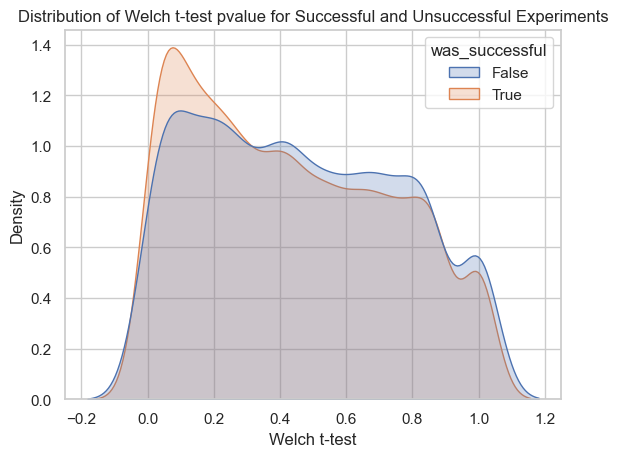

In [18]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot KDE
sns.kdeplot(
    data=df[df.welch_pvalue.notnull()],
    x="welch_pvalue",
    hue="was_successful",
    common_norm=False,  # To scale each density curve independently
    fill=True           # Fill under the KDE curves
)

# Set labels and titles if desired
plt.title("Distribution of Welch t-test pvalue for Successful and Unsuccessful Experiments")
plt.xlabel("Welch t-test")
plt.ylabel("Density")

# Show the plot
plt.show()

In [55]:
s = pandas.Series([1,2,3,4,5,6])
s.mean()

3.5

In [56]:
s.std()

1.8708286933869707

In [57]:
s = pandas.Series([1,2,3,4,5,6,7,8])
s.mean()

4.5

In [58]:
s.std()

2.449489742783178